# Scikit Learn - Original features

In [1]:
# # For data cleaning, structuring, analysis, and visualization
# # we will be using pandas and numpy:
# =============================================================================

import pandas as pd
import numpy as np
import os            # for directory management
import json
import textwrap
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import plotly as py
import plotly_express as px
import plotly.offline as p_off
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import OneClassSVM

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


print(pd.__version__)

1.1.5


In [10]:
import dask
print(dask.__version__)

2.5.2


# Data cleaning and transformation

In [17]:
data=pd.read_excel('clustering_sample_lending_data.xlsx')
# display dataset structure with the pandas .info() method
display(data.info())
#encode the object colums we intend to use for clustering
cat_columns=['employment_status','Gender','credit_score']
le = LabelEncoder()
for cat in cat_columns:
    data[cat] = le.fit_transform(data[cat])
print(data.dtypes)

#further examine our data
display(data.describe().apply(lambda s: s.apply('{0:.3f}'.format)))

#standard deviation and the mean values vary significantly between columns. 
#When working with metrics such as Euclidean distance in the k-means algorithm,
#different scales between the columns can become problematic. 
#we should standardize the data before applying the clustering algorithm.
scaler = StandardScaler()
numeric_cols = data.select_dtypes(include=['int', 'int64']).columns.tolist()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
display(data.describe().apply(lambda s: s.apply('{0:.3f}'.format)))
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customer_id                500 non-null    object
 1   total_loans                500 non-null    int64 
 2   employment_status          500 non-null    object
 3   delayed_supplier_payments  500 non-null    int64 
 4   Gender                     500 non-null    object
 5   monthly_sales              500 non-null    int64 
 6   monthly_turnover           500 non-null    int64 
 7   businesses                 500 non-null    int64 
 8   employees                  500 non-null    int64 
 9   dependants                 500 non-null    int64 
 10  defaulted_loans            500 non-null    int64 
 11  business_experience_years  500 non-null    int64 
 12  credit_score               500 non-null    object
dtypes: int64(9), object(4)
memory usage: 50.9+ KB


None

customer_id                  object
total_loans                   int64
employment_status             int32
delayed_supplier_payments     int64
Gender                        int32
monthly_sales                 int64
monthly_turnover              int64
businesses                    int64
employees                     int64
dependants                    int64
defaulted_loans               int64
business_experience_years     int64
credit_score                  int32
dtype: object


,total_loans,employment_status,delayed_supplier_payments,Gender,monthly_sales,monthly_turnover,businesses,employees,dependants,defaulted_loans,business_experience_years,credit_score
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,1.262,0.134,0.680,0.696,253875.890,1754511.736,1.486,3.042,2.832,0.066,4.938,8.320
std,0.512,0.341,1.353,0.460,815079.369,35770941.658,0.834,2.597,1.753,0.319,2.023,1.714
min,1.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,70000.000,58750.000,1.000,2.000,2.000,0.000,4.000,8.000
50%,1.000,0.000,0.000,1.000,141000.000,100000.000,1.000,3.000,3.000,0.000,5.000,9.000
75%,1.000,0.000,1.000,1.000,200000.000,180000.000,2.000,3.000,4.000,0.000,5.000,9.000
max,3.000,1.000,4.000,1.000,15000000.000,800005000.000,10.000,42.000,10.000,3.000,15.000,10.000


,total_loans,employment_status,delayed_supplier_payments,Gender,monthly_sales,monthly_turnover,businesses,employees,dependants,defaulted_loans,business_experience_years,credit_score
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-0.512,-0.393,-0.503,-1.513,-0.312,-0.049,-1.784,-1.172,-1.617,-0.207,-2.443,-4.858
25%,-0.512,-0.393,-0.503,-1.513,-0.226,-0.047,-0.583,-0.402,-0.475,-0.207,-0.464,-0.187
50%,-0.512,-0.393,-0.503,0.661,-0.139,-0.046,-0.583,-0.016,0.096,-0.207,0.031,0.397
75%,-0.512,-0.393,0.237,0.661,-0.066,-0.044,0.617,-0.016,0.667,-0.207,0.031,0.397
max,3.400,2.542,2.457,0.661,18.110,22.338,10.222,15.015,4.092,9.203,4.978,0.981


,customer_id,total_loans,employment_status,delayed_supplier_payments,Gender,monthly_sales,monthly_turnover,businesses,employees,dependants,defaulted_loans,business_experience_years,credit_score
0,c_1,3.399645,-0.393363,0.236836,-1.513101,-0.244240,-0.047838,-0.583469,-0.787002,-1.045957,-0.207016,-0.958730,0.980864
1,c_2,-0.512490,-0.393363,2.457170,0.660895,0.670697,-0.046299,1.817638,-0.016187,-0.475020,-0.207016,0.030671,-0.186831
2,c_3,3.399645,-0.393363,-0.503276,0.660895,-0.225819,-0.048678,0.617085,-1.172410,-1.616894,-0.207016,-1.948131,0.980864
3,c_4,-0.512490,-0.393363,-0.503276,0.660895,-0.100552,-0.045740,-0.583469,-0.016187,-1.616894,-0.207016,0.030671,0.397016
4,c_5,-0.512490,-0.393363,1.717059,0.660895,-0.127570,-0.044900,-0.583469,-0.016187,-0.475020,-0.207016,0.030671,-0.770679


# Clustering with Scikit learn

In [27]:
data.iloc[:, 1:]

,total_loans,employment_status,delayed_supplier_payments,Gender,monthly_sales,monthly_turnover,businesses,employees,dependants,defaulted_loans,business_experience_years,credit_score
0,3.399645,-0.393363,0.236836,-1.513101,-0.244240,-0.047838,-0.583469,-0.787002,-1.045957,-0.207016,-0.958730,0.980864
1,-0.512490,-0.393363,2.457170,0.660895,0.670697,-0.046299,1.817638,-0.016187,-0.475020,-0.207016,0.030671,-0.186831
2,3.399645,-0.393363,-0.503276,0.660895,-0.225819,-0.048678,0.617085,-1.172410,-1.616894,-0.207016,-1.948131,0.980864
3,-0.512490,-0.393363,-0.503276,0.660895,-0.100552,-0.045740,-0.583469,-0.016187,-1.616894,-0.207016,0.030671,0.397016
4,-0.512490,-0.393363,1.717059,0.660895,-0.127570,-0.044900,-0.583469,-0.016187,-0.475020,-0.207016,0.030671,-0.770679
5,-0.512490,-0.393363,1.717059,0.660895,0.056645,-0.046719,-0.583469,-0.016187,0.095917,-0.207016,0.030671,0.397016
6,1.443578,-0.393363,0.236836,-1.513101,-0.293364,-0.048538,-0.583469,-0.016187,-0.475020,-0.207016,0.030671,-0.186831
7,-0.512490,-0.393363,0.236836,-1.513101,-0.238100,-0.046299,-0.583469,-0.016187,0.095917,-0.207016,0.030671,0.397016
8,3.399645,-0.393363,0.236836,0.660895,-0.090727,-0.046299,-0.583469,-0.016187,0.095917,-0.207016,0.030671,0.397016
9,-0.512490,-0.393363,-0.503276,0.660895,-0.066165,-0.043501,-0.583469,-0.016187,-1.045957,-0.207016,0.030671,-0.770679


In [29]:
from sklearn.cluster import KMeans
# Use scikit-learn to cluster the data
kmeans = KMeans(n_clusters=4, random_state=123)

kmeans.fit(data.iloc[:, 1:])

# Get the cluster assignments from scikit-learn
labels_sklearn = kmeans.labels_

# Add the cluster column to the data
data['cluster'] = labels_sklearn

data.head()

,customer_id,total_loans,employment_status,delayed_supplier_payments,Gender,monthly_sales,monthly_turnover,businesses,employees,dependants,defaulted_loans,business_experience_years,credit_score,cluster
0,c_1,3.399645,-0.393363,0.236836,-1.513101,-0.244240,-0.047838,-0.583469,-0.787002,-1.045957,-0.207016,-0.958730,0.980864,1
1,c_2,-0.512490,-0.393363,2.457170,0.660895,0.670697,-0.046299,1.817638,-0.016187,-0.475020,-0.207016,0.030671,-0.186831,0
2,c_3,3.399645,-0.393363,-0.503276,0.660895,-0.225819,-0.048678,0.617085,-1.172410,-1.616894,-0.207016,-1.948131,0.980864,0
3,c_4,-0.512490,-0.393363,-0.503276,0.660895,-0.100552,-0.045740,-0.583469,-0.016187,-1.616894,-0.207016,0.030671,0.397016,0
4,c_5,-0.512490,-0.393363,1.717059,0.660895,-0.127570,-0.044900,-0.583469,-0.016187,-0.475020,-0.207016,0.030671,-0.770679,0


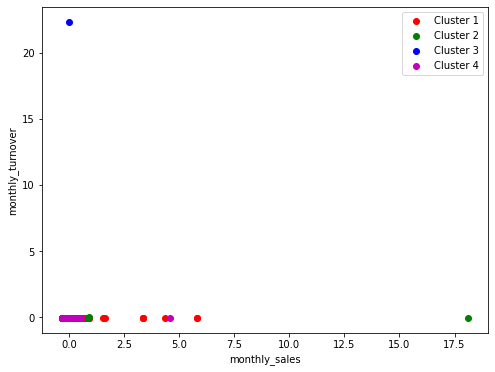

In [46]:
import matplotlib.pyplot as plt

# Plot a scatter chart to visualize the clusters
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['r', 'g', 'b', 'm']
for i in range(4):
    ax.scatter(
        data.loc[data['cluster'] == i, 'monthly_sales'], 
        data.loc[data['cluster'] == i, 'monthly_turnover'], 
        c=colors[i], 
        label=f'Cluster {i+1}'
    )
ax.set_xlabel('monthly_sales')
ax.set_ylabel('monthly_turnover')
ax.legend()
plt.show()

# Clustering with Elki

In [51]:
pip install dask==2021.06.0

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement dask==2021.06.0 (from versions: 0.7.4.linux-x86_64, 0.7.5.linux-x86_64, 0.7.6.linux-x86_64, 0.8.1.macosx-10.5-x86_64, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.2.6, 0.3.0, 0.4.0, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.1, 0.12.0, 0.13.0rc1, 0.13.0, 0.14.0, 0.14.1, 0.14.2, 0.14.3, 0.15.0, 0.15.1, 0.15.2, 0.15.3, 0.15.4, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.17.2, 0.17.3, 0.17.4, 0.17.5, 0.18.0, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.20.0, 0.20.1, 0.20.2, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.4.0, 2.5.0, 2.5.2, 2.6.0, 2.7.0, 2.8.0, 2.8.1, 2.9.0, 2.9.1, 2.9.2, 2.10.0, 2.10.1, 2.11.0, 2.12.0, 2.13.0, 2.14.0, 2.15.0, 2.16.0, 2.17.0, 2.17.1, 2.17.2, 2.18.0, 2.18.1, 2.19.0, 2.20.0, 2.21.0, 2.22.0, 2.23.0, 2.24.0, 2.25.0, 2.26.0, 2.27.0, 2.28.0, 2.29.0, 2.30.

In [52]:
pip install elki-interface "dask>=2021.06.0"

  Using cached https://files.pythonhosted.org/packages/6e/44/930db7fca97e1f3d029596dd0c0d068a4befd3467e405ffaea2ec7dafff7/elki_interface-0.0.12-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement dask>=2021.06.0 (from versions: 0.7.4.linux-x86_64, 0.7.5.linux-x86_64, 0.7.6.linux-x86_64, 0.8.1.macosx-10.5-x86_64, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.2.6, 0.3.0, 0.4.0, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.1, 0.12.0, 0.13.0rc1, 0.13.0, 0.14.0, 0.14.1, 0.14.2, 0.14.3, 0.15.0, 0.15.1, 0.15.2, 0.15.3, 0.15.4, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.17.2, 0.17.3, 0.17.4, 0.17.5, 0.18.0, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.20.0, 0.20.1, 0.20.2, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.4.0, 2.5.0, 2.5.2, 2.6.0, 2.7.0, 2.8.0, 2.8.1, 2.9.0, 2.9.1, 2.9.2, 2.10.0, 2.10.1, 2.11.0, 2.12.0, 2.13.0, 2.14.0, 2.15.0, 2.16.0, 2.17.0, 2.17.1, 2.17.2, 2.18.0, 2.18.1, 2.19.0, 2.20.0, 2.21.0, 2.22.0, 2.23.0, 2.24.0, 2.25.0, 2.26.0, 2.27.0, 2.28.0, 2.29.0, 2.30.

In [6]:
pip install  dask

Note: you may need to restart the kernel to use updated packages.


In [8]:
!dask -V

'dask' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
from elki_interface import ElkiInterface

ModuleNotFoundError: No module named 'elki_interface'

In [ ]:
from pyelki import Elki

In [ ]:
# Use ELKI to cluster the data
elki = Elki()
elki.set_features(data[['num1', 'num2', 'category_encoded']])
elki.set_algorithm('clustering.kmeans.KMeans')
elki.set_params({'k': 4, 'distanceFunction': 'EuclideanDistanceFunction'})
elki.run()

# Get the cluster assignments from ELKI
labels_elki = elki.get_labels()